# ARIMA

In [1]:
suppressMessages(library(tidyverse))
suppressMessages(library(tsibble))
suppressMessages(library(fable))
suppressMessages(library(tsibble))
suppressMessages(library(fabletools))
suppressMessages(library(feasts))
suppressMessages(library(lubridate))
suppressMessages(library(scales))
suppressMessages(library(fpp3))
suppressMessages(library(gridExtra))

In [2]:
plot_prefix <- 'plots/w07_'

## Stationary

### Google Price Level

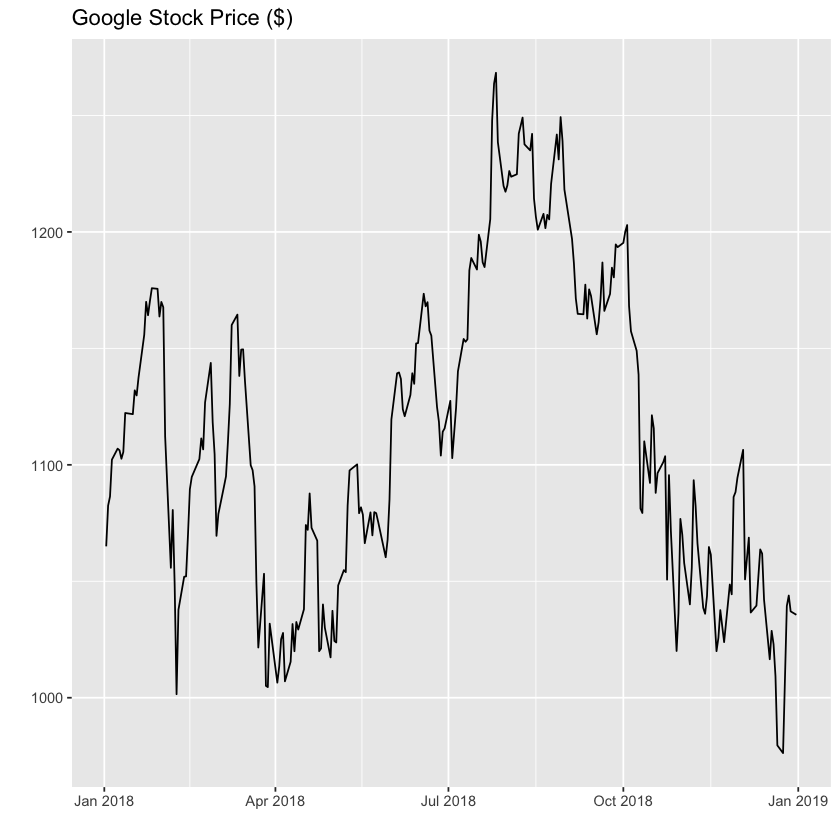

In [3]:
goog <- gafa_stock %>% filter(Symbol == 'GOOG') %>% filter(Date >= as.Date('2018-01-01'))

goog %>% autoplot(Close) + labs(x='', y='', title='Google Stock Price ($)')

ggsave(paste(plot_prefix, '_goog.png', sep=''), height = 3, width=5)

Warning message:
"Provided data has an irregular interval, results should be treated with caution. Computing ACF by observation."


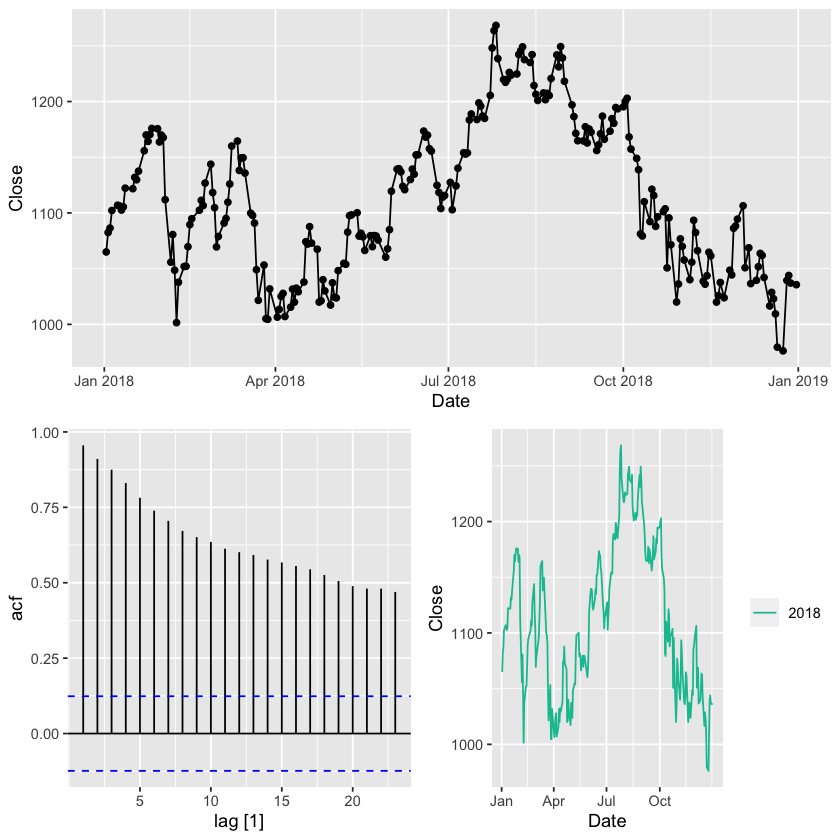

In [4]:
goog %>% gg_tsdisplay(Close)

In [5]:
goog %>% features(Close, ljung_box, lag=10)

Symbol,lb_stat,lb_pvalue
<chr>,<dbl>,<dbl>
GOOG,1581.212,0


In [6]:
goog %>% features(Close, ljung_box, lag=10)

Symbol,lb_stat,lb_pvalue
<chr>,<dbl>,<dbl>
GOOG,1581.212,0


### Change or Difference in Google's Price

Warning message:
"Removed 1 row containing missing values (`geom_line()`)."
Warning message:
"Removed 1 row containing missing values (`geom_line()`)."


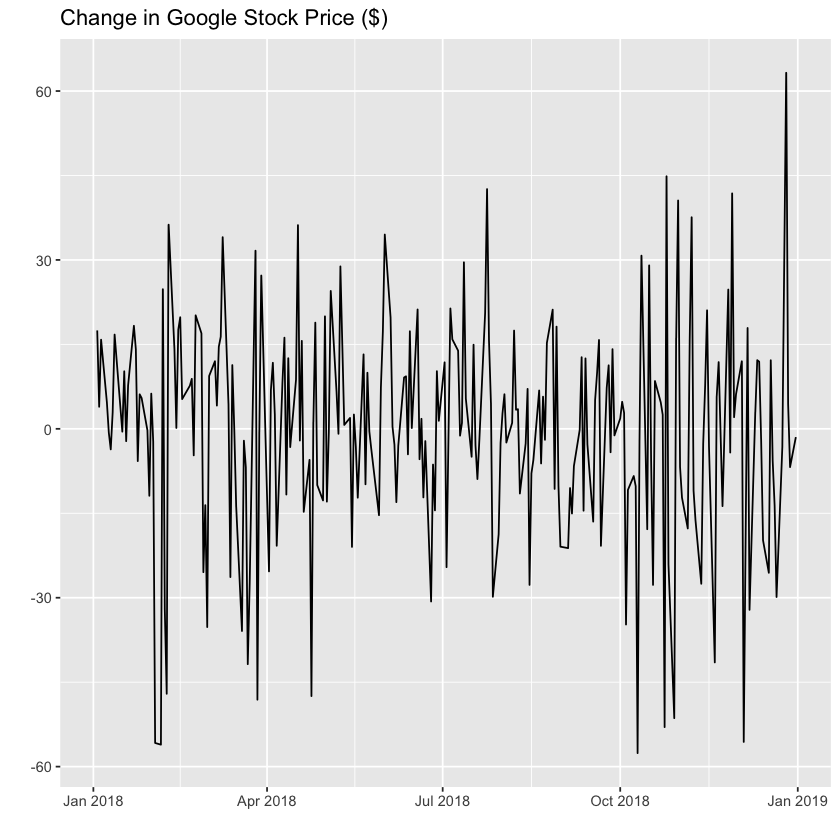

In [7]:
goog %>% autoplot(difference(Close))+ labs(x='', y='', title='Change in Google Stock Price ($)')

ggsave(paste(plot_prefix, '_goog_chg.png', sep=''), height = 3, width=5)

Warning message:
"Provided data has an irregular interval, results should be treated with caution. Computing ACF by observation."


Warning message:
"Removed 1 row containing missing values (`geom_line()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 1 row containing missing values (`geom_line()`)."


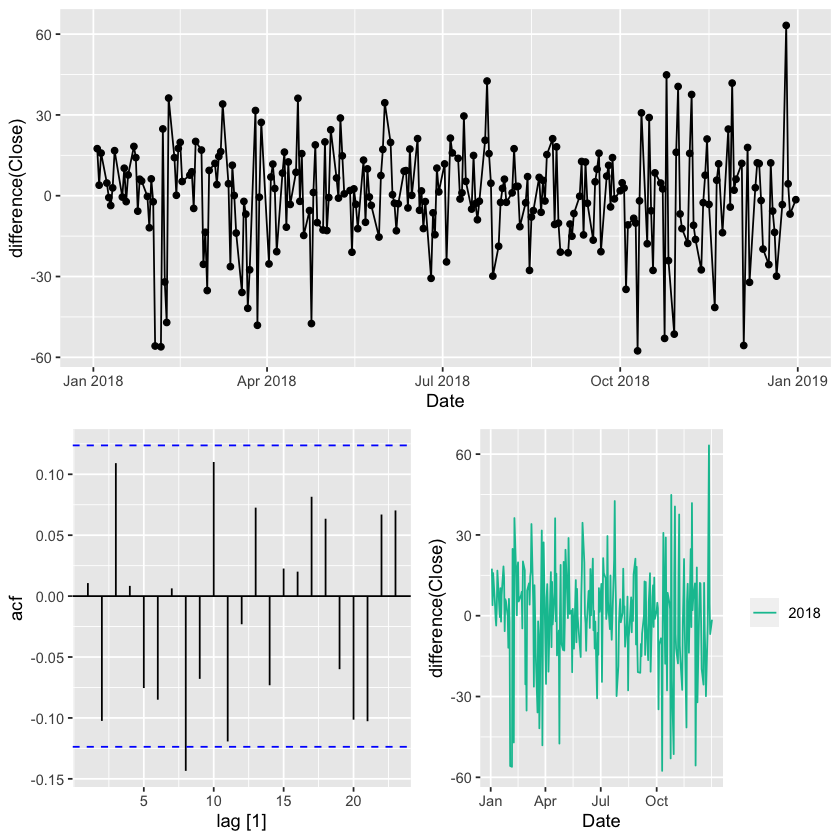

In [8]:
goog %>% gg_tsdisplay(difference(Close))

In [9]:
goog %>% features(difference(Close), ljung_box, lag=10)

Symbol,lb_stat,lb_pvalue
<chr>,<dbl>,<dbl>
GOOG,18.83816,0.04236708


### Differenced-Log in Google's Stock Price

Warning message:
"Provided data has an irregular interval, results should be treated with caution. Computing ACF by observation."


Warning message:
"Removed 1 row containing missing values (`geom_line()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 1 row containing missing values (`geom_line()`)."


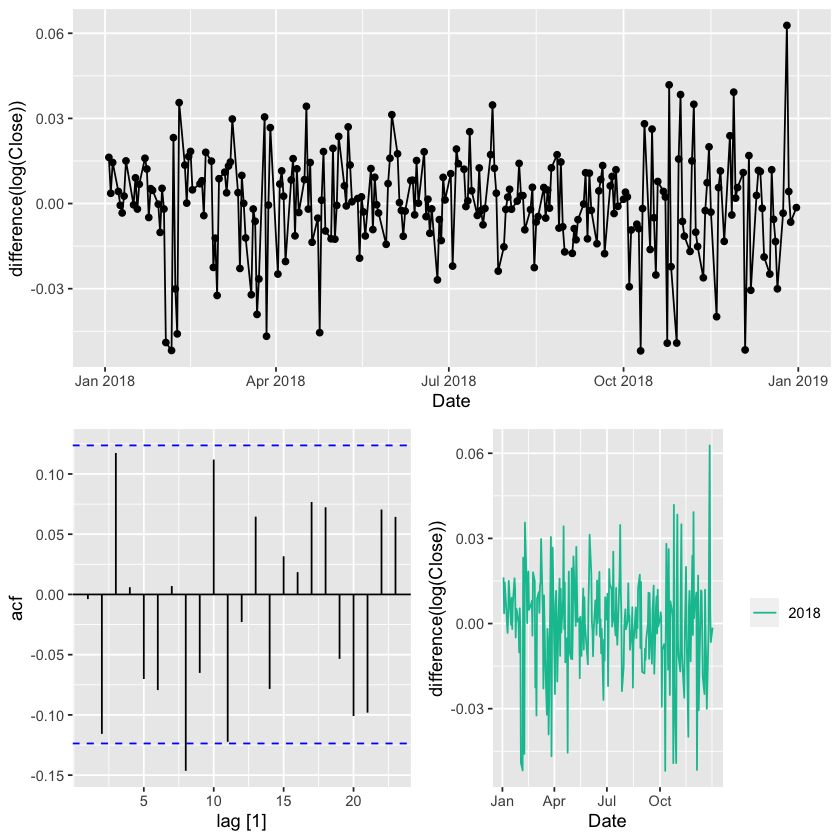

In [10]:
goog %>% gg_tsdisplay(difference(log(Close)))

In [11]:
goog %>% features(difference(log(Close),differences=1), ljung_box, lags=10)

Symbol,lb_stat,lb_pvalue
<chr>,<dbl>,<dbl>
GOOG,0.003779718,0.9509774


## Seasonal Differencing

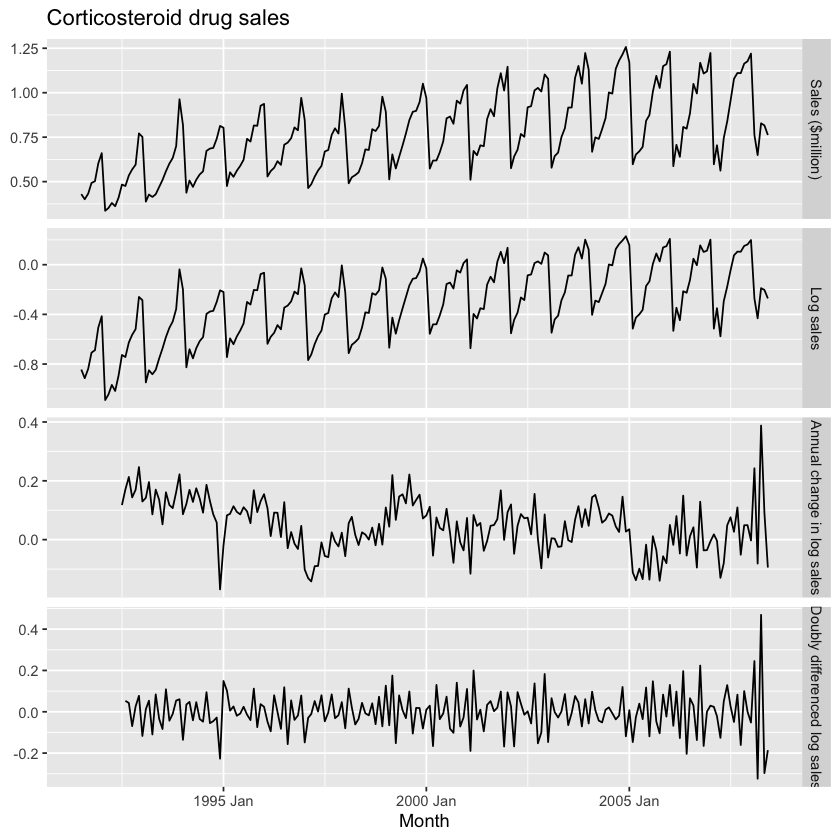

In [12]:
drugs <- PBS |>
  filter(ATC2 == "H02") |>
  summarise(Cost = sum(Cost)/1e6) |>
  transmute(
    `Sales ($million)` = Cost,
    `Log sales` = log(Cost),
    `Annual change in log sales` = difference(log(Cost), 12),
    `Doubly differenced log sales` =
                     difference(difference(log(Cost), 12), 1)
  ) |>
  pivot_longer(-Month, names_to="Type", values_to="Sales") |>
  mutate(
    Type = factor(Type, levels = c(
      "Sales ($million)",
      "Log sales",
      "Annual change in log sales",
      "Doubly differenced log sales"))
  )

  drugs %>%
  ggplot(aes(x = Month, y = Sales)) +
  geom_line() +
  facet_grid(vars(Type), scales = "free_y") +
  labs(title = "Corticosteroid drug sales", y = NULL)

Plot variable not specified, automatically selected `y = Sales`


Warning message:
"Removed 12 rows containing missing values (`geom_line()`)."
Warning message:
"Removed 12 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 12 rows containing missing values (`geom_line()`)."


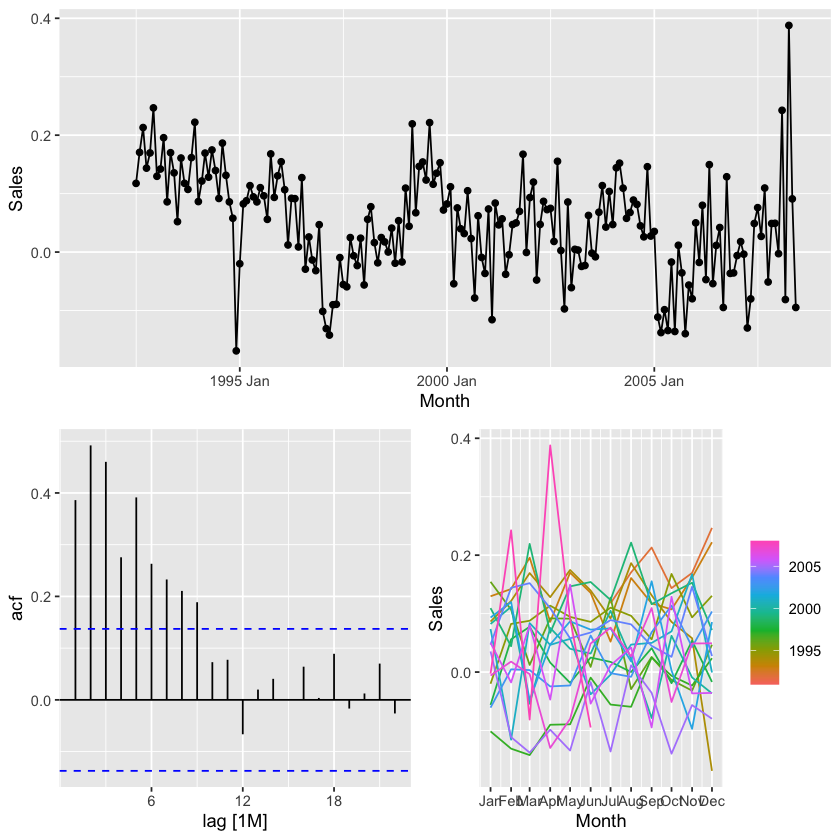

In [13]:
drugs %>% filter(Type == "Annual change in log sales") %>% gg_tsdisplay()

In [14]:
drugs %>% filter(Type == "Annual change in log sales") %>%
features(Sales, ljung_box, lags=12)

Type,lb_stat,lb_pvalue
<fct>,<dbl>,<dbl>
Annual change in log sales,29.08129,6.940393e-08


Plot variable not specified, automatically selected `y = Sales`
Warning message:
"Removed 13 rows containing missing values (`geom_line()`)."
Warning message:
"Removed 13 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 13 rows containing missing values (`geom_line()`)."


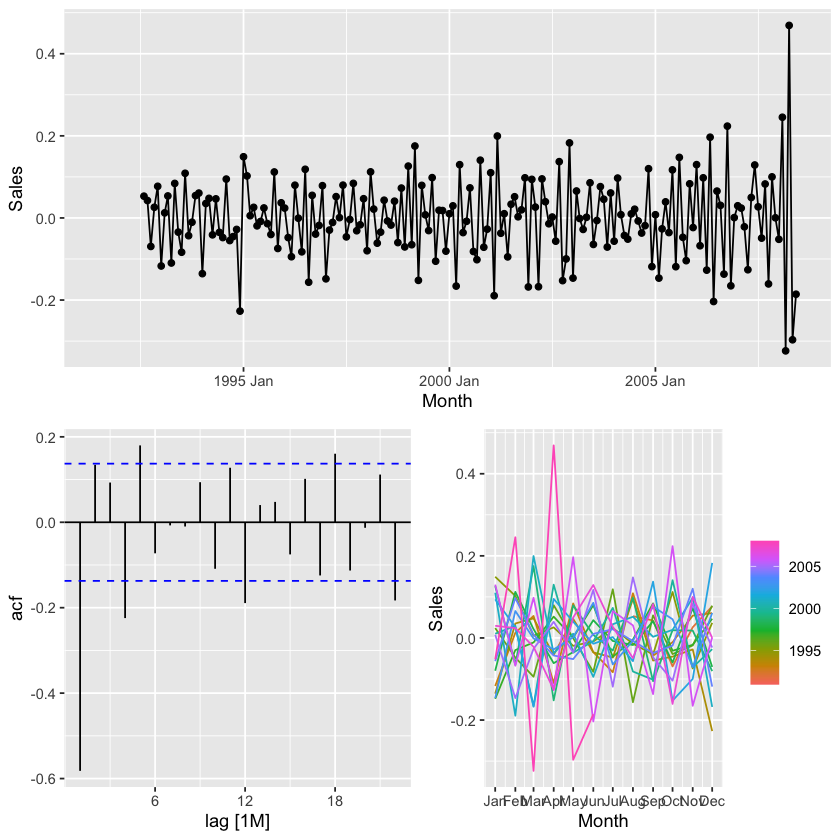

In [15]:
drugs %>% filter(Type == "Doubly differenced log sales") %>% gg_tsdisplay()

In [16]:
drugs %>% filter(Type == "Doubly differenced log sales") %>%
features(Sales, ljung_box, lags=12)

Type,lb_stat,lb_pvalue
<fct>,<dbl>,<dbl>
Doubly differenced log sales,65.71028,5.551115e-16


## Unit Root Tests

In [17]:
goog %>% features(Close, unitroot_kpss)

Symbol,kpss_stat,kpss_pvalue
<chr>,<dbl>,<dbl>
GOOG,0.5730076,0.02522351


In [18]:
goog %>% features(difference(Close), unitroot_kpss)

Symbol,kpss_stat,kpss_pvalue
<chr>,<dbl>,<dbl>
GOOG,0.09551033,0.1


In [19]:
goog %>% features(Close, unitroot_ndiffs)

Symbol,ndiffs
<chr>,<int>
GOOG,1


## ARMA Example

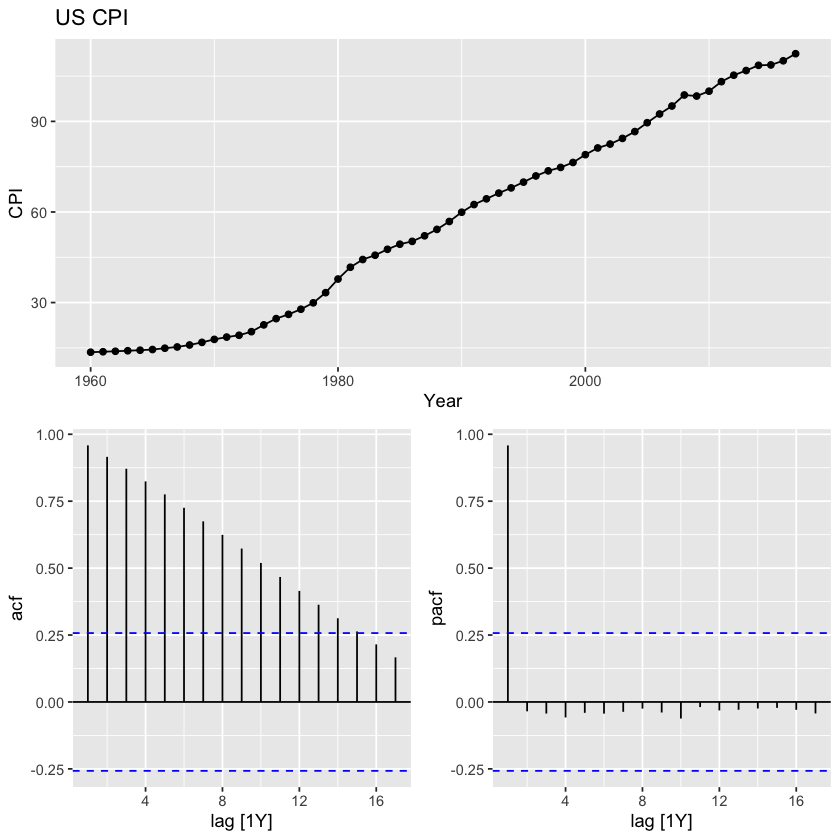

In [20]:
usa <- global_economy %>% filter(Code == "USA")
usa %>% gg_tsdisplay(CPI, plot_type = 'partial') + labs(title='US CPI')

In [21]:
usa %>% model(ARIMA(CPI)) %>% report()

Series: CPI 
Model: ARIMA(1,1,0) w/ drift 

Coefficients:
         ar1  constant
      0.6186    0.6513
s.e.  0.1049    0.1044

sigma^2 estimated as 0.6793:  log likelihood=-69.08
AIC=144.16   AICc=144.62   BIC=150.29


## Modeling Processing Using CPI

In [22]:
cpi <- read.csv('data/CPIAUCSL.csv') %>%
mutate(DATE = yearmonth(as.Date(DATE))) %>%
as_tsibble(index=DATE) %>%
rename(`Price Index` = CPIAUCSL)

cpi %>% head()

DATE,Price Index
<mth>,<dbl>
1947 Jan,21.48
1947 Feb,21.62
1947 Mar,22.00
1947 Apr,22.00
1947 May,21.95
1947 Jun,22.08


### Plot the data and observe

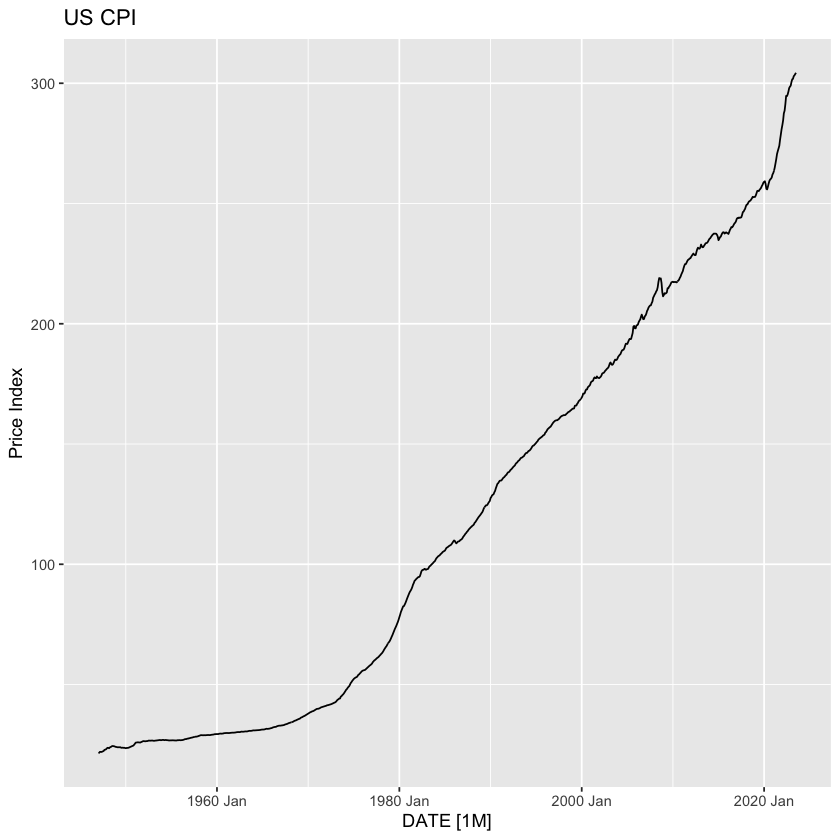

In [27]:
cpi %>% autoplot(`Price Index`) + labs(title='US CPI')
ggsave(paste(plot_prefix, '_ex_cpi_lvl_plot.png', sep=''), height = 3, width = 5)

Warning message:
"Removed 1 row containing missing values (`geom_line()`)."
Warning message:
"Removed 1 row containing missing values (`geom_line()`)."


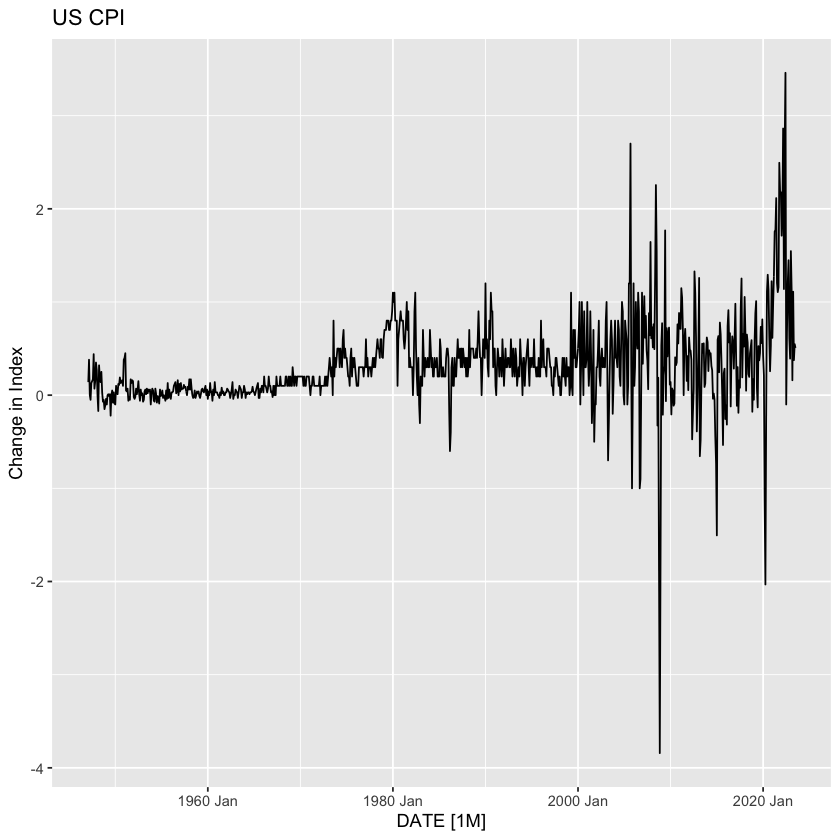

In [28]:
cpi %>% autoplot(difference(`Price Index`)) + labs(title='US CPI', y='Change in Index')
ggsave(paste(plot_prefix, '_ex_cpi_chg_plot.png', sep=''), height = 3, width = 5)

### Need to remove the exponential trend, take the log of the time series

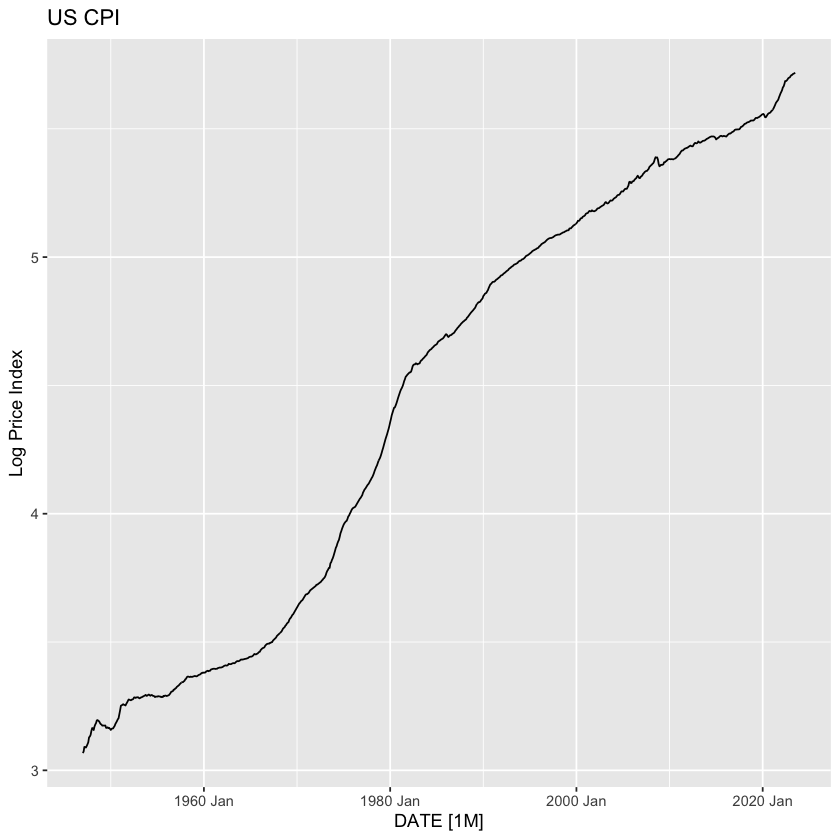

In [32]:
cpi %>% autoplot(log(`Price Index`)) + labs(title='US CPI', y='Log Price Index')
ggsave(paste(plot_prefix, '_ex_cpi_log_lvl_plot.png', sep=''), height = 3, width = 5)

Warning message:
"Removed 1 row containing missing values (`geom_line()`)."
Warning message:
"Removed 1 row containing missing values (`geom_line()`)."


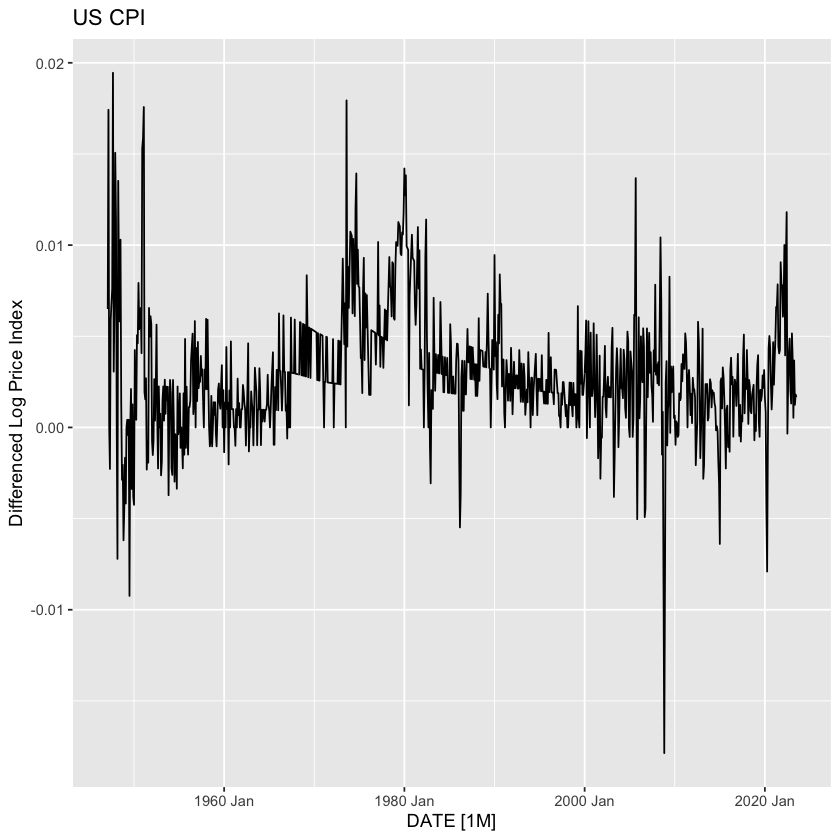

In [33]:
cpi %>% autoplot(difference(log(`Price Index`))) + labs(title='US CPI', y='Differenced Log Price Index')
ggsave(paste(plot_prefix, '_ex_cpi_log_chg_plot.png', sep=''), height = 3, width = 5)

### Determine number of differences

In [30]:
cpi %>% features(log(`Price Index`), unitroot_ndiffs)

ndiffs
<int>
2


Warning message:
"Removed 2 rows containing missing values (`geom_line()`)."
Warning message:
"Removed 2 rows containing missing values (`geom_line()`)."


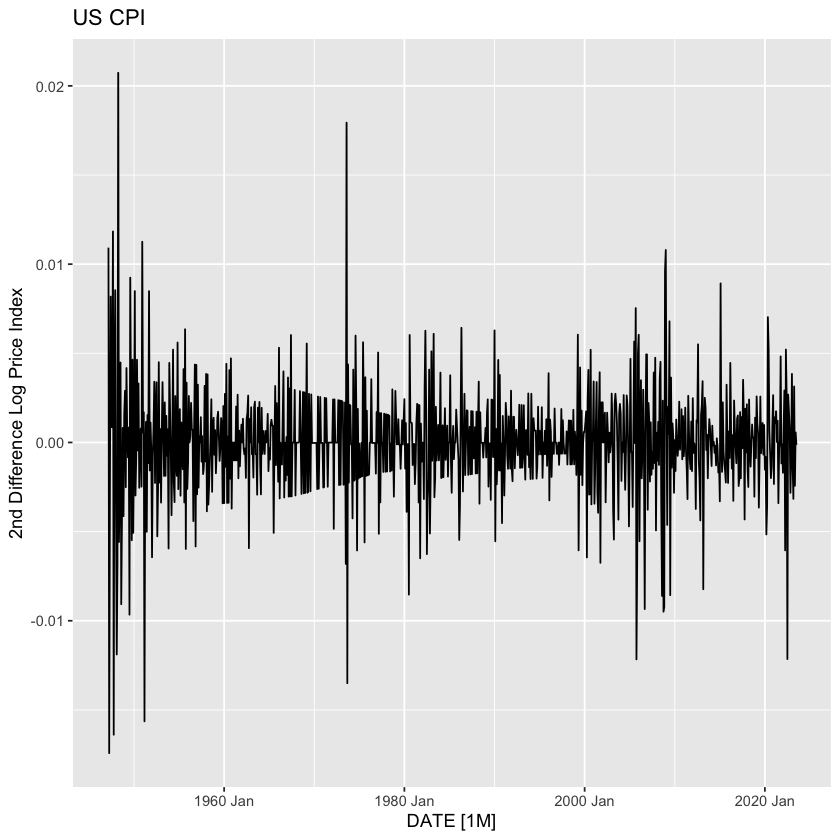

In [35]:
cpi %>% autoplot(difference(log(`Price Index`), differences=2)) + labs(title='US CPI', y='2nd Difference Log Price Index')
ggsave(paste(plot_prefix, '_ex_cpi_log_chg_in_chg_plot.png', sep=''), height = 3, width = 5)

### ACF and PACFs on Differenced Data to Determine p, q seed

Warning message:
"Removed 2 rows containing missing values (`geom_line()`)."
Warning message:
"Removed 2 rows containing missing values (`geom_point()`)."


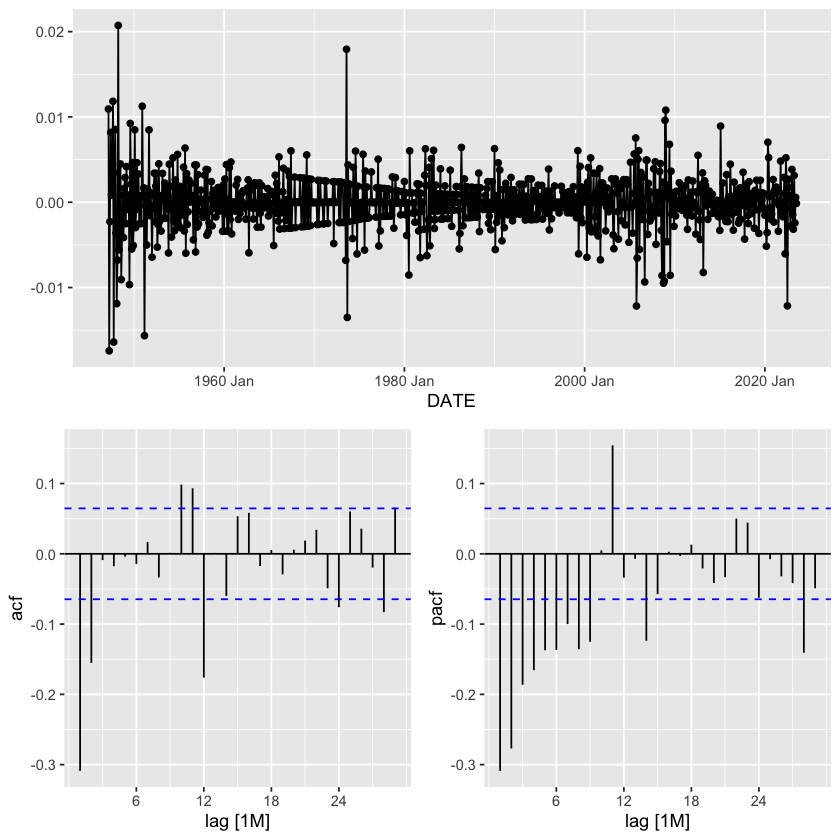

In [37]:
cpi %>% gg_tsdisplay(difference(log(`Price Index`), differences=2), plot_type = 'partial') + labs(y='')

### Model around a ARIMA(0,2,2) seed

In [42]:
cpi %>%
model(ARIMA(log(`Price Index`) ~ pdq(0:1,1:2,1:3)+PDQ(0,0,0))) %>% report()

Warning message in sqrt(diag(best$var.coef)):
"NaNs produced"


Series: Price Index 
Model: ARIMA(1,2,3) 
Transformation: log(`Price Index`) 

Coefficients:
          ar1     ma1      ma2      ma3
      -0.7265  0.1665  -0.6602  -0.1801
s.e.      NaN     NaN      NaN   0.0179

sigma^2 estimated as 7.373e-06:  log likelihood=4120.06
AIC=-8230.12   AICc=-8230.05   BIC=-8206.01


Warning message in sqrt(diag(best$var.coef)):
"NaNs produced"


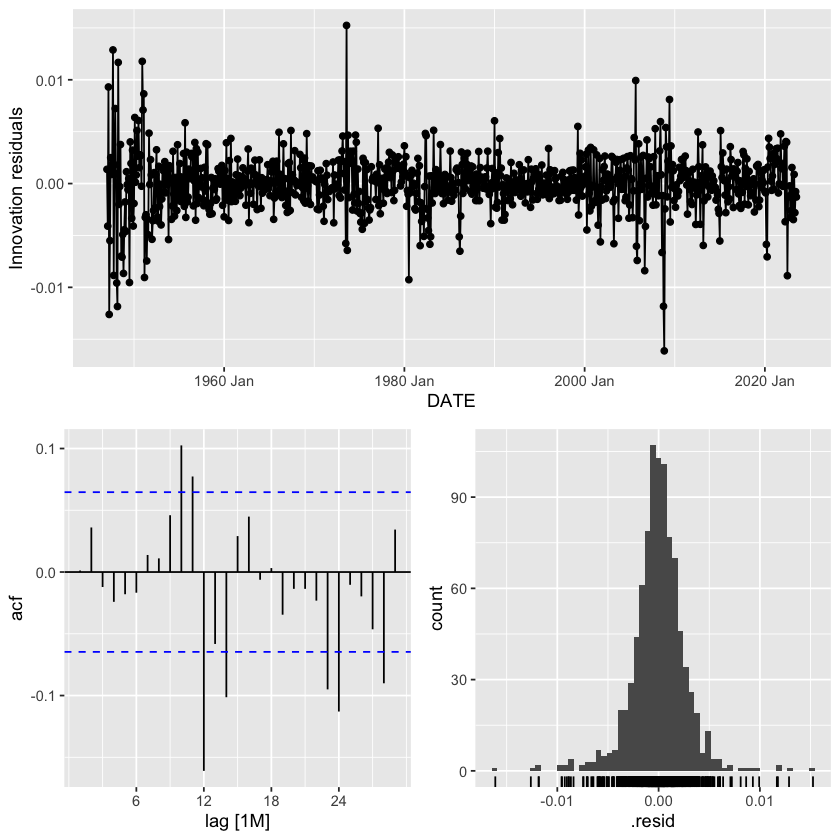

In [101]:
cpi_arima <- cpi %>%
model(ARIMA(log(`Price Index`) ~ 0 + pdq(0:1,1:2,1:3)+PDQ(0,0,0)))

cpi_arima %>% gg_tsresiduals()

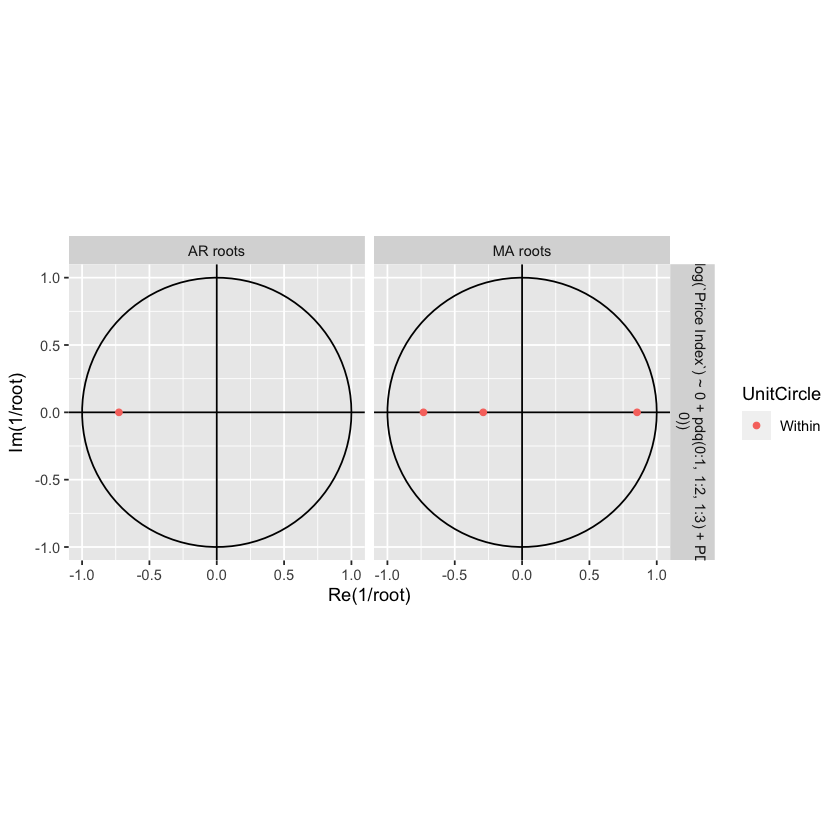

In [102]:
gg_arma(cpi_arima)

### Compare to Seasonal Model

In [103]:
cpi_sarima <- cpi %>%
model(
    `Non Seasonal ARIMA` = ARIMA(log(`Price Index`) ~ 0+ pdq(1,2,3) + PDQ(0,0,0)),
    `Seasonal ARIMA` = ARIMA(log(`Price Index`) ~ 0+ pdq(1,2,3)+PDQ(1,0,0))
)

cpi_sarima %>% report() %>% select(.model, AICc)

Warning message in sqrt(diag(best$var.coef)):
"NaNs produced"
Warning message in sqrt(diag(best$var.coef)):
"NaNs produced"
Warning message in report.mdl_df(.):
"Model reporting is only supported for individual models, so a glance will be shown. To see the report for a specific model, use `select()` and `filter()` to identify a single model."


.model,AICc
<chr>,<dbl>
Non Seasonal ARIMA,-8230.051
Seasonal ARIMA,-8257.856


In [104]:
cpi_sarima %>% select(`Non Seasonal ARIMA`) %>% report()

Series: Price Index 
Model: ARIMA(1,2,3) 
Transformation: log(`Price Index`) 

Coefficients:
          ar1     ma1      ma2      ma3
      -0.7265  0.1665  -0.6602  -0.1801
s.e.      NaN     NaN      NaN   0.0179

sigma^2 estimated as 7.373e-06:  log likelihood=4120.06
AIC=-8230.12   AICc=-8230.05   BIC=-8206.01


In [105]:
cpi_sarima %>% select(`Seasonal ARIMA`) %>% report()

Series: Price Index 
Model: ARIMA(1,2,3)(1,0,0)[12] 
Transformation: log(`Price Index`) 

Coefficients:
          ar1     ma1      ma2     ma3     sar1
      -0.6655  0.1118  -0.6136  -0.162  -0.1893
s.e.      NaN     NaN      NaN     NaN   0.0343

sigma^2 estimated as 7.142e-06:  log likelihood=4134.97
AIC=-8257.95   AICc=-8257.86   BIC=-8229.02


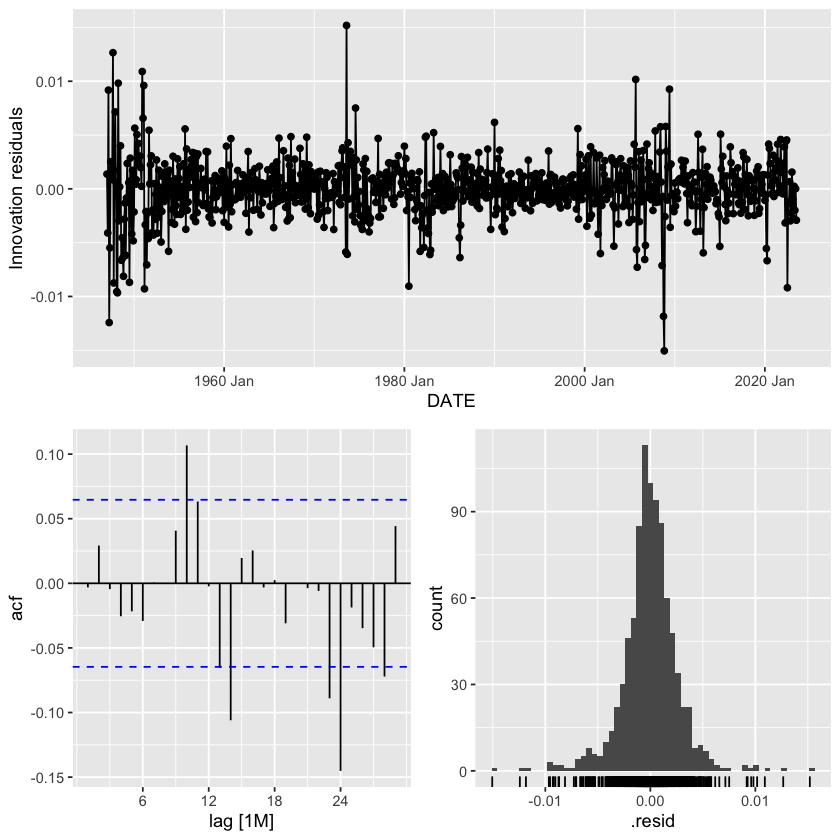

In [106]:
cpi_sarima %>% select(`Seasonal ARIMA`) %>% gg_tsresiduals()

### Compare to Automate Modeling

In [108]:
cpi_auto <- cpi %>%
model(ARIMA(log(`Price Index`))) 

cpi_auto %>% report()

Series: Price Index 
Model: ARIMA(1,2,1)(2,0,0)[12] 
Transformation: log(`Price Index`) 

Coefficients:
         ar1      ma1     sar1     sar2
      0.2970  -0.8773  -0.2080  -0.1732
s.e.  0.0414   0.0219   0.0346   0.0362

sigma^2 estimated as 6.973e-06:  log likelihood=4145.11
AIC=-8280.22   AICc=-8280.15   BIC=-8256.11


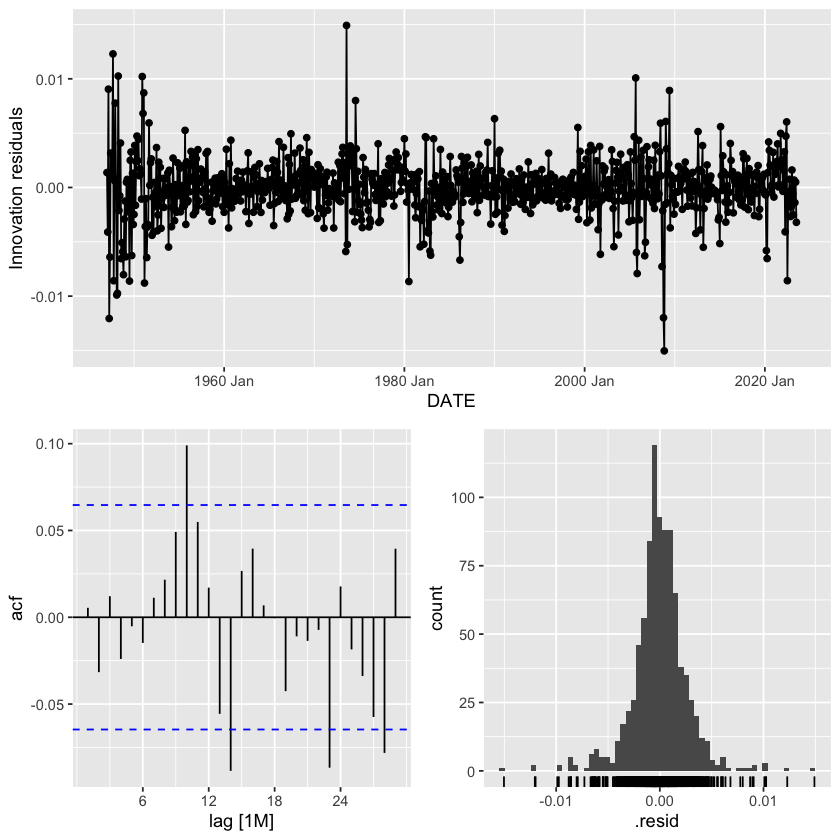

In [109]:
cpi_auto %>% gg_tsresiduals()

In [110]:
augment(cpi_auto) |> features(.innov, ljung_box, lag = 12, dof = 3)

.model,lb_stat,lb_pvalue
<chr>,<dbl>,<dbl>
ARIMA(log(`Price Index`)),16.8558,0.05102265


### Forecast Using the Best Model (the automatic selection)

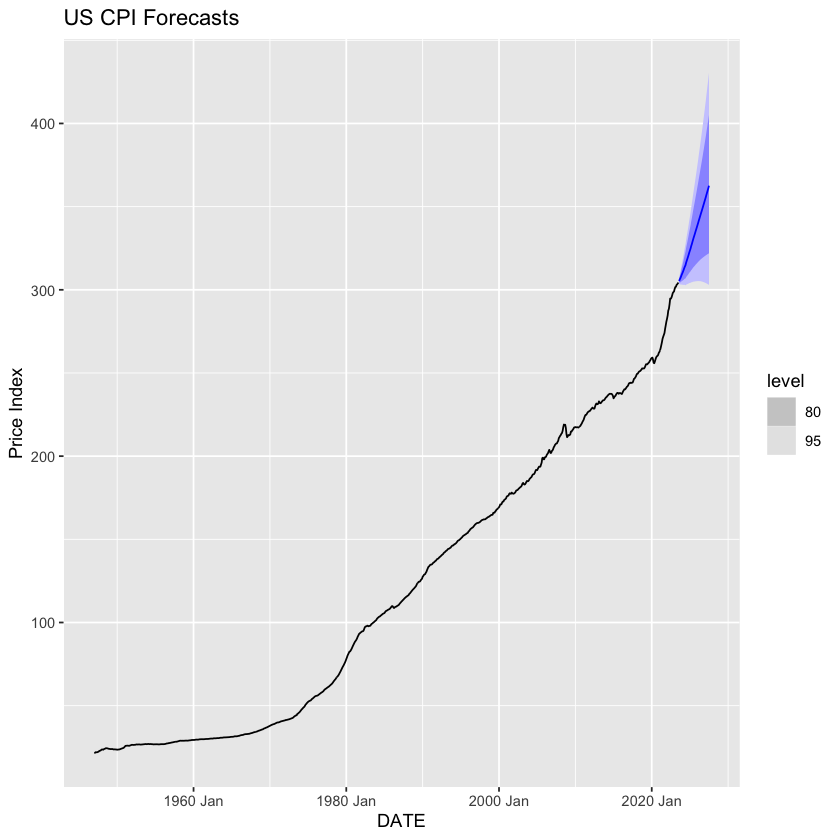

In [117]:
cpi_auto %>% forecast(h=48) %>% autoplot(cpi) + labs(title='US CPI Forecasts')

### ARIMA vs ETS

In [122]:
cpi_training <- cpi %>% filter_index(. ~ 'Dec 2020')
cpi_test <- cpi %>% filter_index('Jan 2021' ~ .)

cpi_models <- cpi_training %>%
model(
    `ARIMA` = ARIMA(log(`Price Index`)),
    `ETS` = ETS(log(`Price Index`))
)

cpi_models %>% report()

Warning message in report.mdl_df(.):
"Model reporting is only supported for individual models, so a glance will be shown. To see the report for a specific model, use `select()` and `filter()` to identify a single model."


.model,sigma2,log_lik,AIC,AICc,BIC,ar_roots,ma_roots,MSE,AMSE,MAE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<list>,<list>,<dbl>,<dbl>,<dbl>
ARIMA,6.921447e-06,4008.775,-8005.550,-8005.454,-7976.830,"0.6684213+0.8474824i, -1.0026111+0.3997306i, -0.3997306-1.0026111i, 1.0026111-0.3997306i, 0.3997306+1.0026111i, -0.8474824+0.6684213i, -0.6684213-0.8474824i, 1.0681520-0.1551286i, 0.1551286+1.0681520i, -1.0681520+0.1551286i, 0.1551286-1.0681520i, 1.0681520+0.1551286i, -0.1551286+1.0681520i, -1.0026111-0.3997306i, 0.3997306-1.0026111i, 1.0026111+0.3997306i, -0.3997306+1.0026111i, -1.0681520-0.1551286i, 0.6684213-0.8474824i, 0.8474824+0.6684213i, -0.6684213+0.8474824i, -0.8474824-0.6684213i, 0.8474824-0.6684213i, -0.1551286-1.0681520i, 3.2379767+0.0000000i","0.610995+1.058274i, -1.058274+0.610995i, -0.610995-1.058274i, 1.128168-0.000000i, 0.000000+1.221990i, -1.221990-0.000000i, -1.058274-0.610995i, 1.221990+0.000000i, -0.610995+1.058274i, 0.000000-1.221990i, 0.610995-1.058274i, 1.058274+0.610995i, 1.058274-0.610995i",NA,NA,NA
ETS,7.808931e-06,2209.249,-4408.497,-4408.429,-4384.553,NULL,NULL,7.773756e-06,2.557145e-05,0.00188785


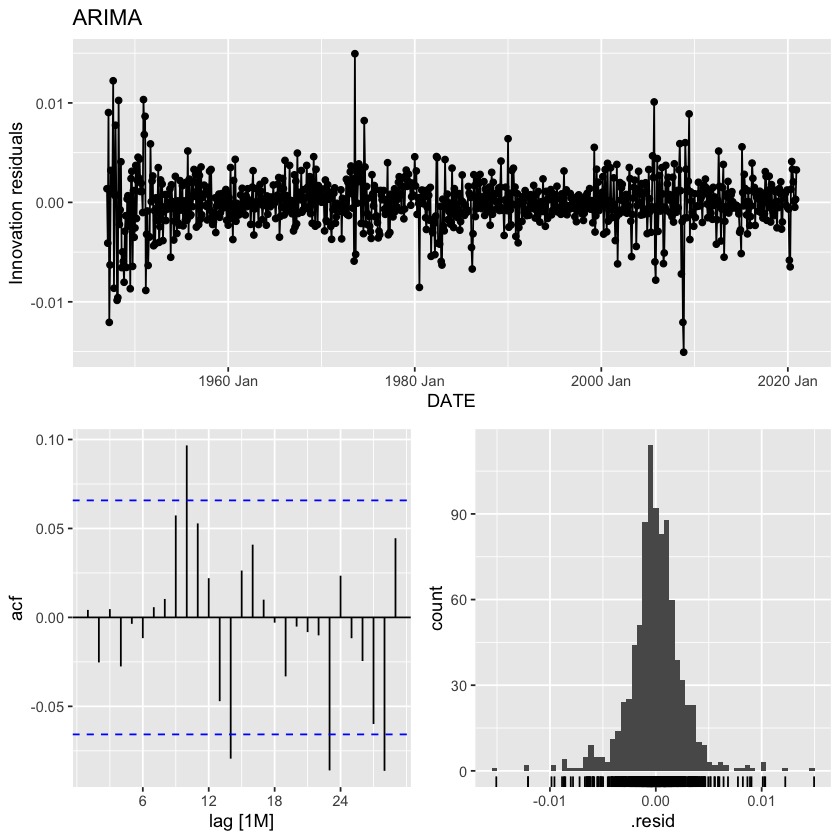

In [131]:
cpi_models %>% select(ARIMA) %>% gg_tsresiduals() + labs(title='ARIMA')

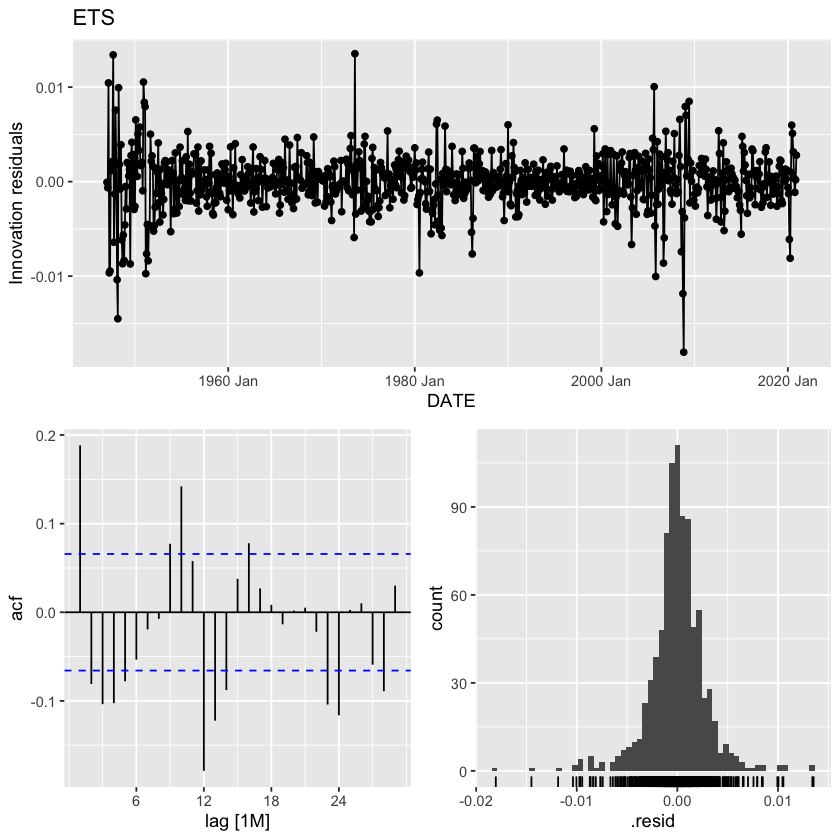

In [132]:
cpi_models %>% select(ETS) %>% gg_tsresiduals() + labs(title='ETS')

In [160]:
bind_rows((cpi_models %>% accuracy()),cpi_models %>% forecast(cpi_test) %>% accuracy(cpi_test)) %>% select(-MASE, -RMSSE, -ME, -MAE, -MPE)

.model,.type,RMSE,MAPE,ACF1
<chr>,<chr>,<dbl>,<dbl>,<dbl>
ARIMA,Training,0.3376495,0.1794815,0.1658854
ETS,Training,0.3732252,0.1888185,0.3189797
ARIMA,Test,17.4455637,5.0709575,0.9274358
ETS,Test,14.9597399,4.4238947,0.9276620


In [150]:
cpi_models %>% select(ETS) %>% report() %>% glance()

Series: Price Index 
Model: ETS(A,A,N) 
Transformation: log(`Price Index`) 
  Smoothing parameters:
    alpha = 0.9999 
    beta  = 0.2560852 

  Initial states:
     l[0]        b[0]
 3.060035 0.007158976

  sigma^2:  0

      AIC      AICc       BIC 
-4408.497 -4408.429 -4384.553 


.model,sigma2,log_lik,AIC,AICc,BIC,MSE,AMSE,MAE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ETS,7.808931e-06,2209.249,-4408.497,-4408.429,-4384.553,7.773756e-06,2.557145e-05,0.00188785


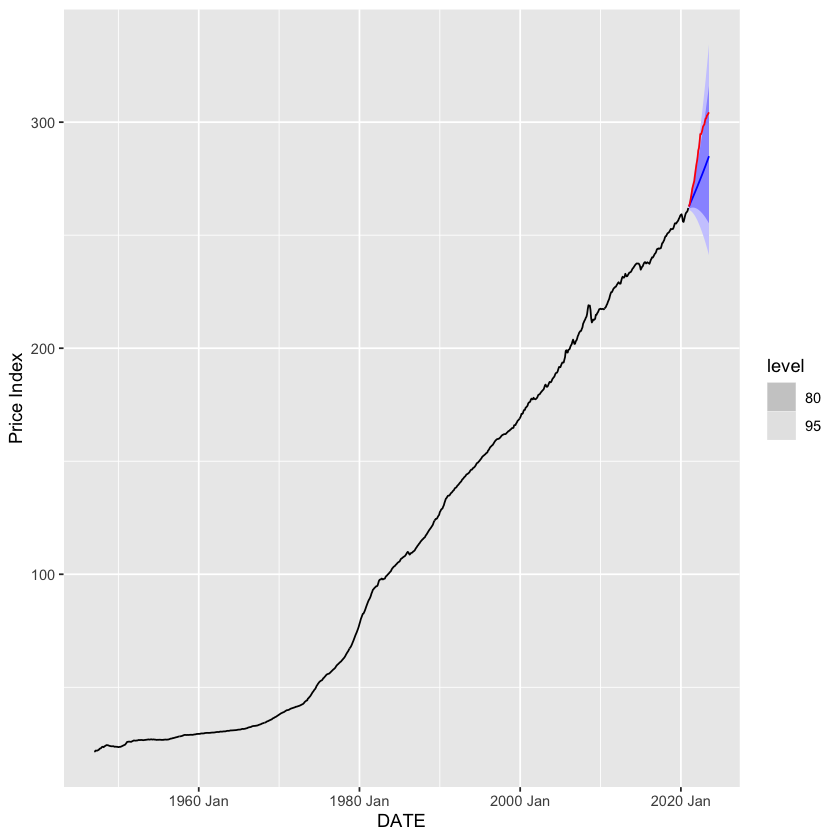

In [158]:
cpi_models %>% select(ETS) %>% forecast(cpi_test) %>% autoplot(cpi_training) +
autolayer(cpi_test, `Price Index`, col='red')

### Retrain and Out-of-Sample

In [169]:
cpi %>% model(ETS(log(`Price Index`))) %>% report()

Series: Price Index 
Model: ETS(A,Ad,N) 
Transformation: log(`Price Index`) 
  Smoothing parameters:
    alpha = 0.9999 
    beta  = 0.286506 
    phi   = 0.9736399 

  Initial states:
     l[0]        b[0]
 3.059217 0.008407614

  sigma^2:  0

      AIC      AICc       BIC 
-4541.161 -4541.069 -4512.222 


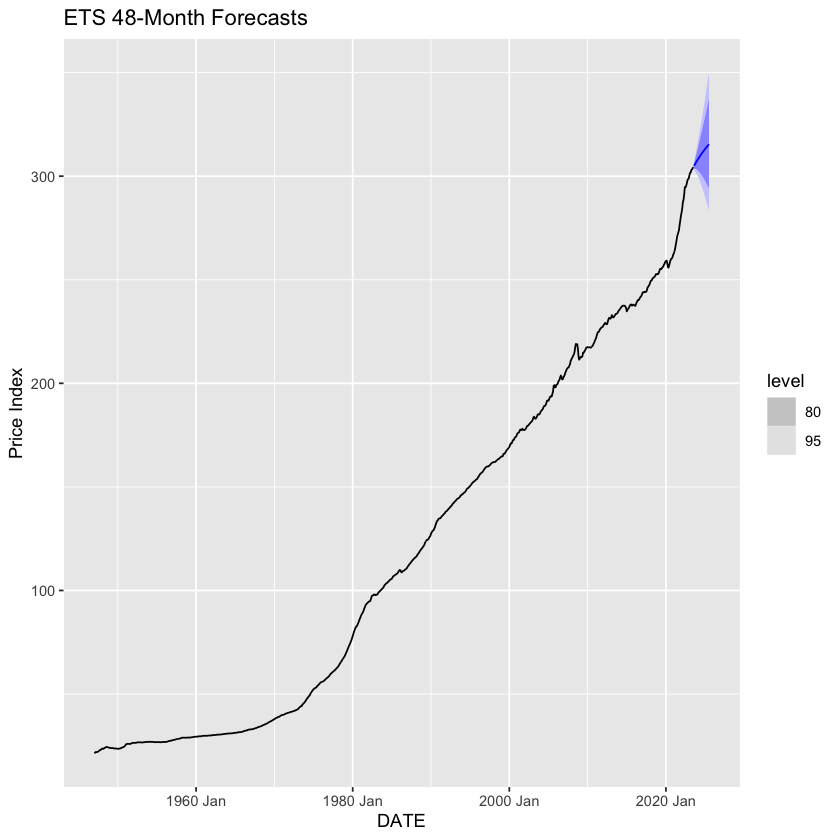

In [166]:
cpi %>% model(ETS(log(`Price Index`))) %>% forecast(horizon=48) %>% autoplot(cpi) + labs(title='ETS 48-Month Forecasts')

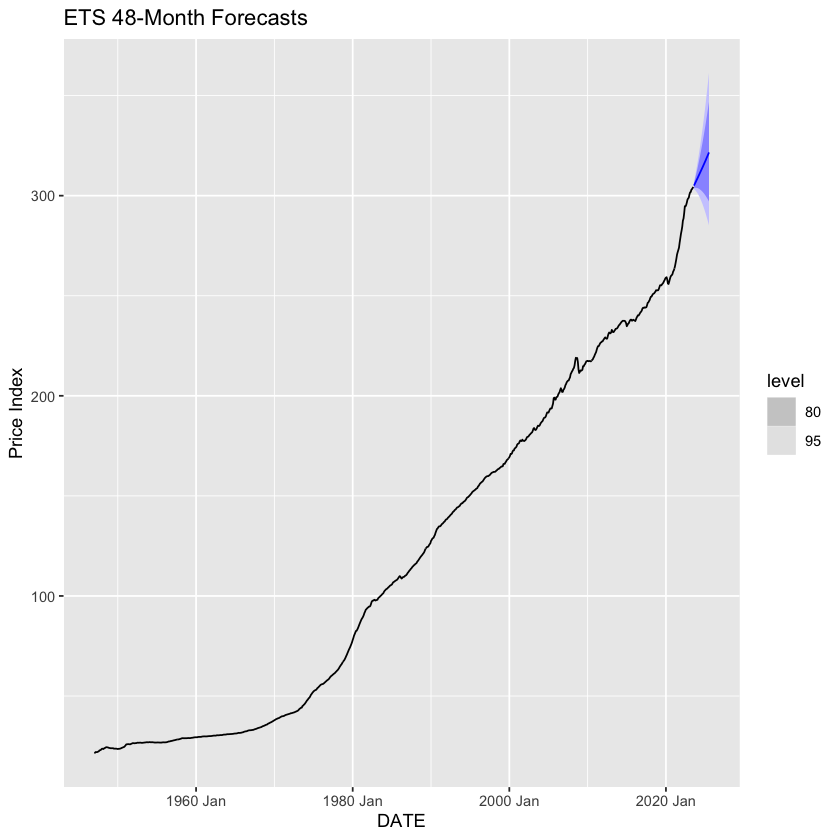

In [171]:
cpi %>% model(ETS(log(`Price Index`)~trend('A')+error('A')+season('N'))) %>% forecast(horizon=48) %>% autoplot(cpi) + labs(title='ETS 48-Month Forecasts')

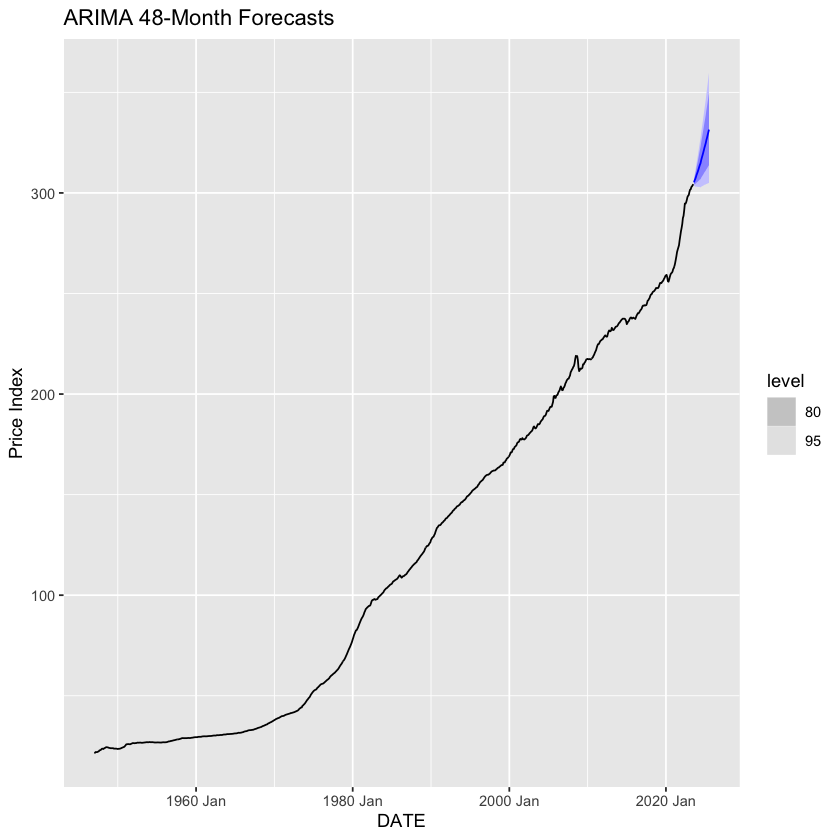

In [168]:
cpi %>% model(ARIMA(log(`Price Index`))) %>% forecast(horizon=48) %>% autoplot(cpi) + labs(title='ARIMA 48-Month Forecasts')